# PM2.5 Observations
## Group 6
### Nicholas Tam, Devansh Chopra, Steven Tsai, Xiao Jin

In [2]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────

## Background Information
From 2010 to 2014, Beijing and a substantial part of China have suffered from chronic air pollution. The main pollutants are PM2.5, otherwise known as particulate matter, referring to tiny particles in the air with aerodynamic diameters of 2.5 micrometers (2.5 * 10^(-6) m or 2.5 μm) or less. (Inhalable Particulate Matter and Health (PM2.5 and PM10)) The presence of high concentrations of PM2.5 in Beijing from 2010 to 2014 has negatively influenced the climate, visibility, and human health. If PM2.5 concentration is exceptionally high, people suggest avoiding outdoor activities to reduce the risk of respiratory diseases. PM2.5 consists of a complex mixture of solids and aerosols, with particles containing various organic and inorganic compounds. Its concentration is highly influenced by meteorological conditions such as temperature and wind speed. (Sun, Ruiling, et al, 2019)

## Dataset and Project Question
For our research project, we have selected a dataset of hourly observations of PM2.5 concentration from 1-1-2010 to 12-31-2014. This dataset was retrieved from https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data and contains the PM2.5 data of the US Embassy in Beijing, as well as the meteorological data from Beijing Capital International Airport. This dataset aims to understand how surrounding temperatures, cumulated wind speed, and humidity in different months affect PM2.5 concentration. Furthermore, we expect the result to give us an insight into which situation is most optimal for outdoor activities in Beijing, such as hiking. 

We predict that:
- There will be a positive correlation between PM2.5 concentration and temperature, as an increase in temperature can affect the formation of particles.
- There will be a negative correlation between PM2.5 concentration and wind speed, as PM2.5 will likely be more dispersed by the winds.
- There will be a negative correlation between PM2.5 concentration and humidity, as the particles will become too heavy to remain in the air, leading to dry deposition, reducing the amount of PM2.5 in the air.

## Graphs
We read the dataset into R as shown below, including a new column for relative humidity called HUMID (%). HUMID is calculated by the formula HUMID = 100 - 5 * (TEMP - DEWP)), where TEMP is the observed temperature and DEWP is the dew point, the temperature the air needs to be cooled to (at constant pressure) in order to achieve a relative humidity of 100%. We have removed the cbwd column due to not being a quantitative variable, while the day and hour columns are too precise to be relevant to the data. PRES, Is and Ir are also removed, as they do not change drastically and frequently enough to be usable, with Is and Ir being limited by the number of snow and rain days in the years respectively, and PRES not changing dratically due to constant altitude.

In [14]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv"
pollution <- read_csv(url)
pollution <- na.omit(pollution)
# pollution[is.na(pollution)] <- 0
pollution <- mutate(pollution, HUMID = 100 - 5 * (TEMP - DEWP))
head(pollution)

Parsed with column specification:
cols(
  No = col_double(),
  year = col_double(),
  month = col_double(),
  day = col_double(),
  hour = col_double(),
  pm2.5 = col_double(),
  DEWP = col_double(),
  TEMP = col_double(),
  PRES = col_double(),
  cbwd = col_character(),
  Iws = col_double(),
  Is = col_double(),
  Ir = col_double()
)



No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,HUMID
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
25,2010,1,2,0,129,-16,-4,1020,SE,1.79,0,0,40
26,2010,1,2,1,148,-15,-4,1020,SE,2.68,0,0,45
27,2010,1,2,2,159,-11,-5,1021,SE,3.57,0,0,70
28,2010,1,2,3,181,-7,-5,1022,SE,5.36,1,0,90
29,2010,1,2,4,138,-7,-5,1022,SE,6.25,2,0,90
30,2010,1,2,5,109,-7,-6,1022,SE,7.14,3,0,95


### Data Splitting

In [15]:
options(repr.matrix.max.rows = 12)
pollution_split <- initial_split(pollution, prop=3/4, strata = pm2.5)
pollution_training <- training(pollution_split)
pollution_testing <- testing(pollution_split)
pollute_avg <- pollution_training %>%
     select(year, month, day, hour, pm2.5, DEWP, TEMP, Iws, HUMID) %>%
     group_by(year,month) %>%
     summarise(pm2.5_avg = mean(pm2.5, na.rm = TRUE),TEMP_avg = mean(TEMP, na.rm = TRUE),Iws_avg = mean(Iws, na.rm = TRUE), HUMID_avg = mean(HUMID, na.rm = TRUE))
pollute_avg

`summarise()` regrouping output by 'year' (override with `.groups` argument)



year,month,pm2.5_avg,TEMP_avg,Iws_avg,HUMID_avg
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010,1,87.89633,-6.559395,37.286825,47.34341
2010,2,99.65079,-1.910714,13.574802,44.30556
2010,3,95.61453,2.899441,24.396704,42.63501
2010,4,78.85206,10.863296,57.504775,29.27903
2010,5,85.93262,20.904255,22.246170,33.37766
2010,6,109.73843,24.375000,9.385787,60.02315
⋮,⋮,⋮,⋮,⋮,⋮
2014,7,89.11504,27.961062,17.270389,56.11504
2014,8,63.03375,25.662522,7.179822,61.20782


### Graphs of Temperature, Wind Speed and Relative Humidity
In our data, we use year and month, TEMP (Surrounding temperature, °C), Iws (Cumulated wind speed, m/s), and HUMID (Relative humidity, %) as three predictors to predict our outcome variable, or pm2.5 (PM2.5, ug/m^3). We generate a scatterplot for TEMP, Iws, and HUMID to see the relationship of all three predictors against pm2.5 using the average values of each month. A regression line is also drawn for each scatterplot to interpret the relationships further. 

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



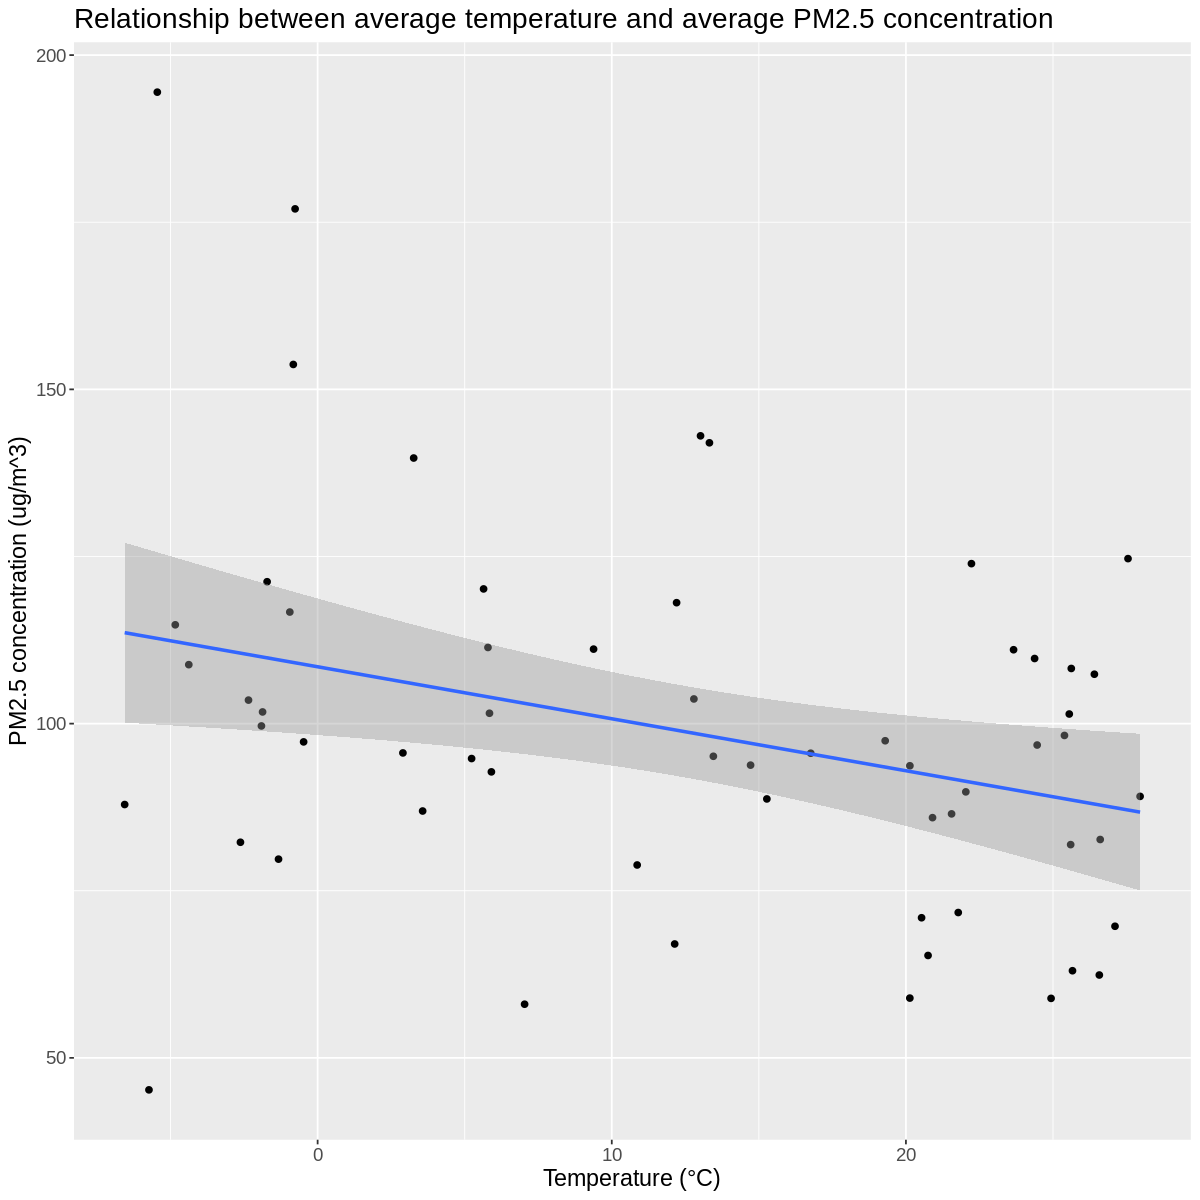

`geom_smooth()` using formula 'y ~ x'



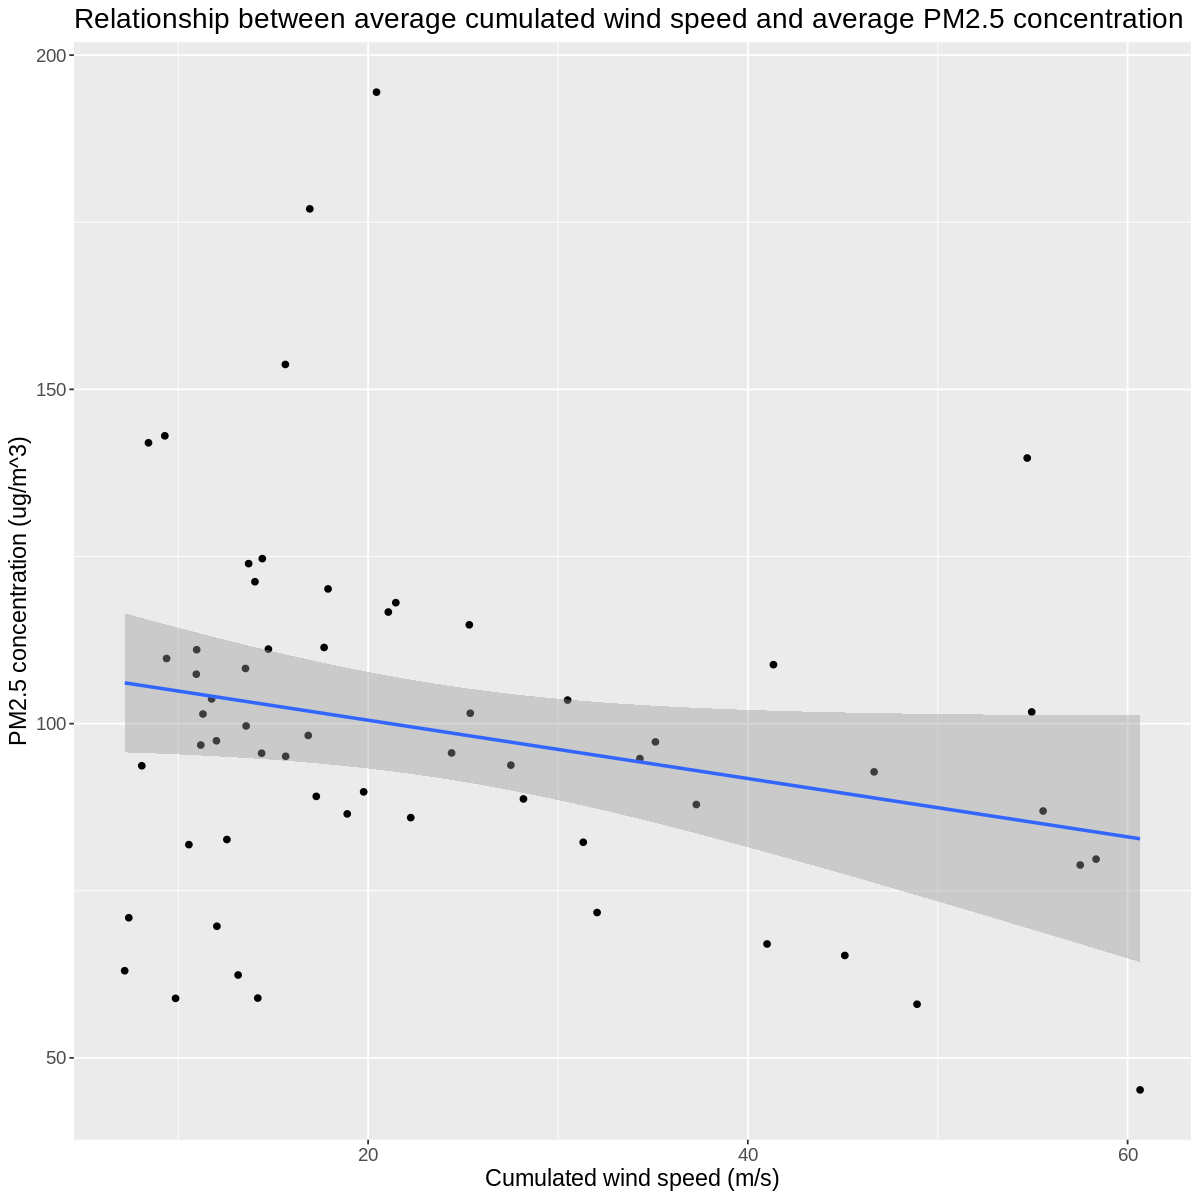

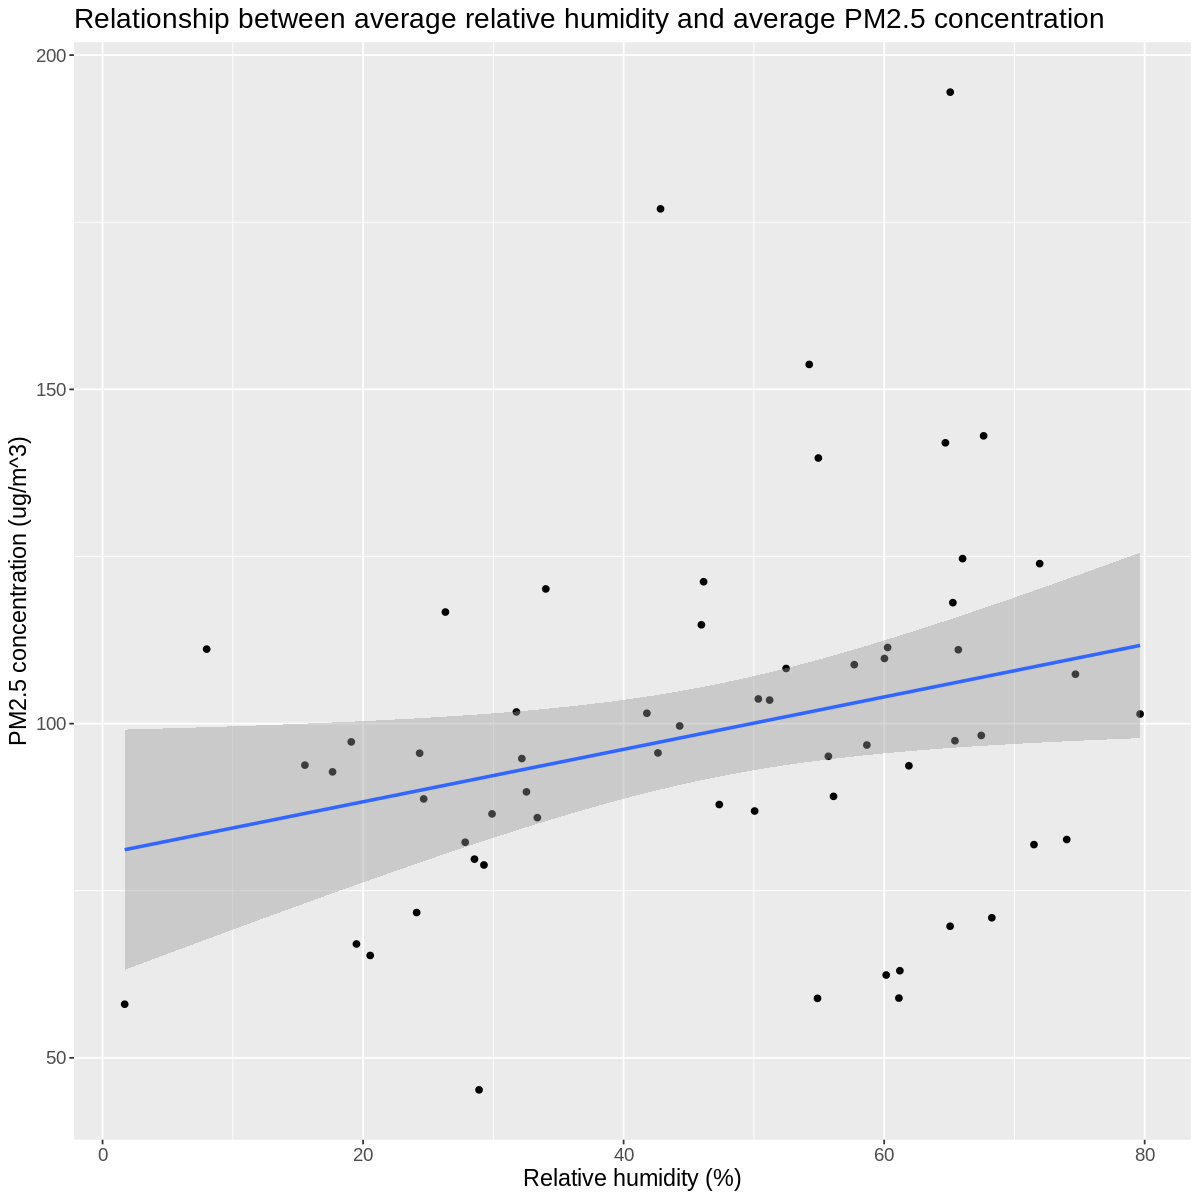

In [16]:
set.seed(9999)
options(repr.plot.width = 10, repr.plot.height = 10)

TEMP_pm2.5_avg_plot <- ggplot(pollute_avg, aes(x = TEMP_avg,y = pm2.5_avg)) +
geom_point() +
geom_smooth(method="lm") +
ggtitle("Relationship between average temperature and average PM2.5 concentration") +
labs(x = "Temperature (°C)",y = "PM2.5 concentration (ug/m^3)") +
theme(text = element_text(size = 14))
TEMP_pm2.5_avg_plot

Iws_pm2.5_avg_plot <- ggplot(pollute_avg, aes(x = Iws_avg,y = pm2.5_avg)) +
geom_point() +
geom_smooth(method="lm") +
ggtitle("Relationship between average cumulated wind speed and average PM2.5 concentration") + 
labs(x = "Cumulated wind speed (m/s)",y = "PM2.5 concentration (ug/m^3)") +
theme(text = element_text(size = 14))
Iws_pm2.5_avg_plot

HUMID_pm2.5_avg_plot <- ggplot(pollute_avg, aes(x = HUMID_avg,y = pm2.5_avg)) +
geom_point() +
geom_smooth(method="lm") +
ggtitle("Relationship between average relative humidity and average PM2.5 concentration") + 
labs(x = "Relative humidity (%)",y = "PM2.5 concentration (ug/m^3)") +
theme(text = element_text(size = 14))
HUMID_pm2.5_avg_plot

Next, we create a histogram for TEMP, Iws, and HUMID to see the distribution of all three predictors using all given observations.

Warning message:
“Removed 6 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


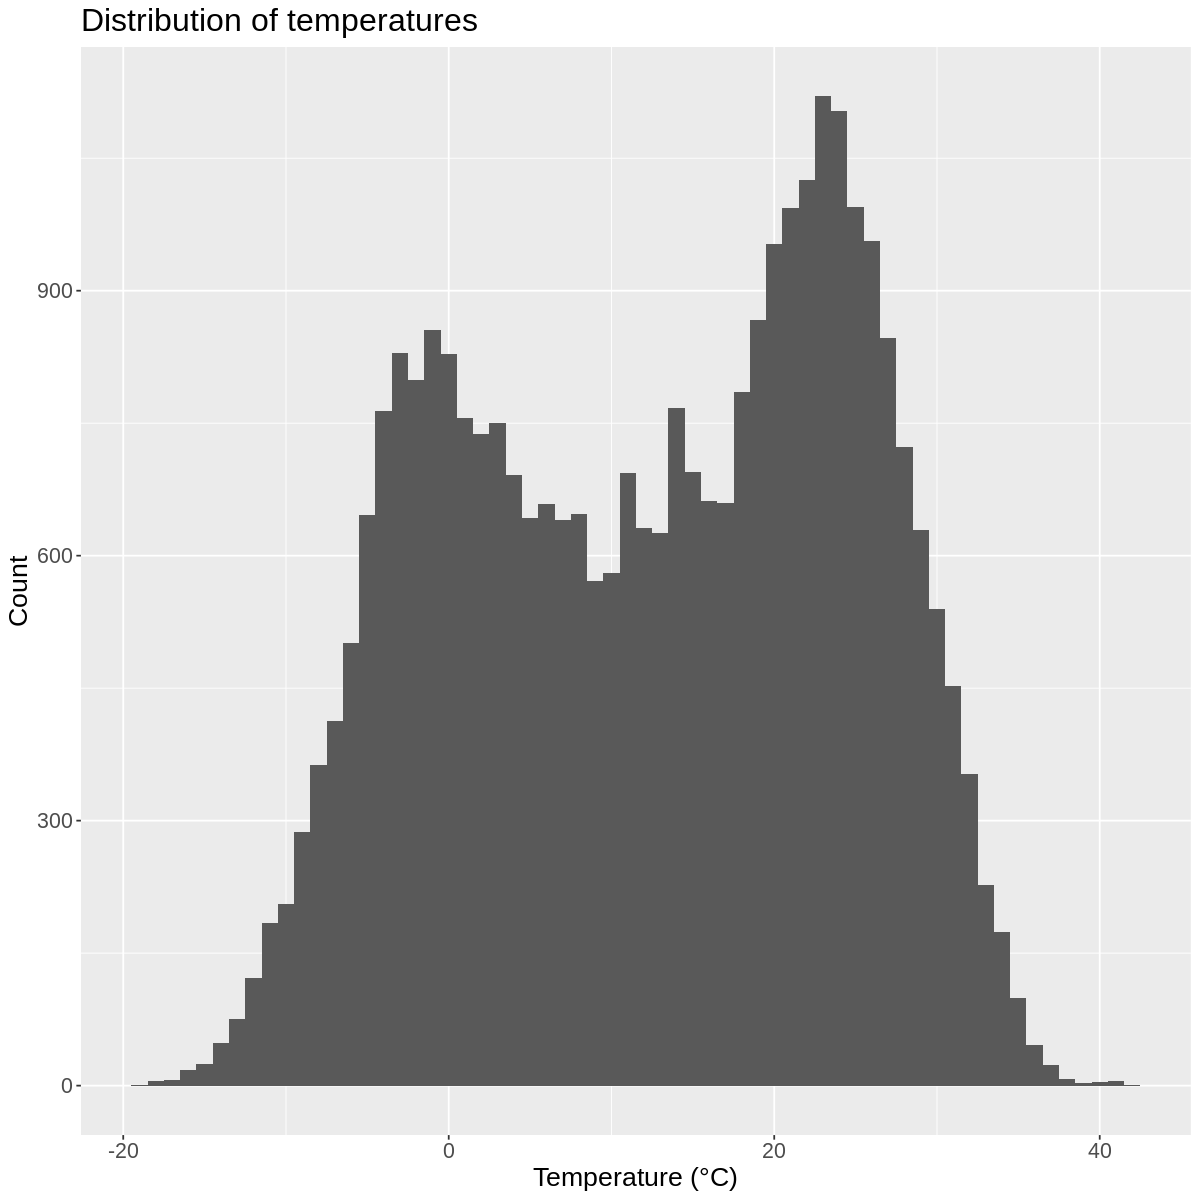

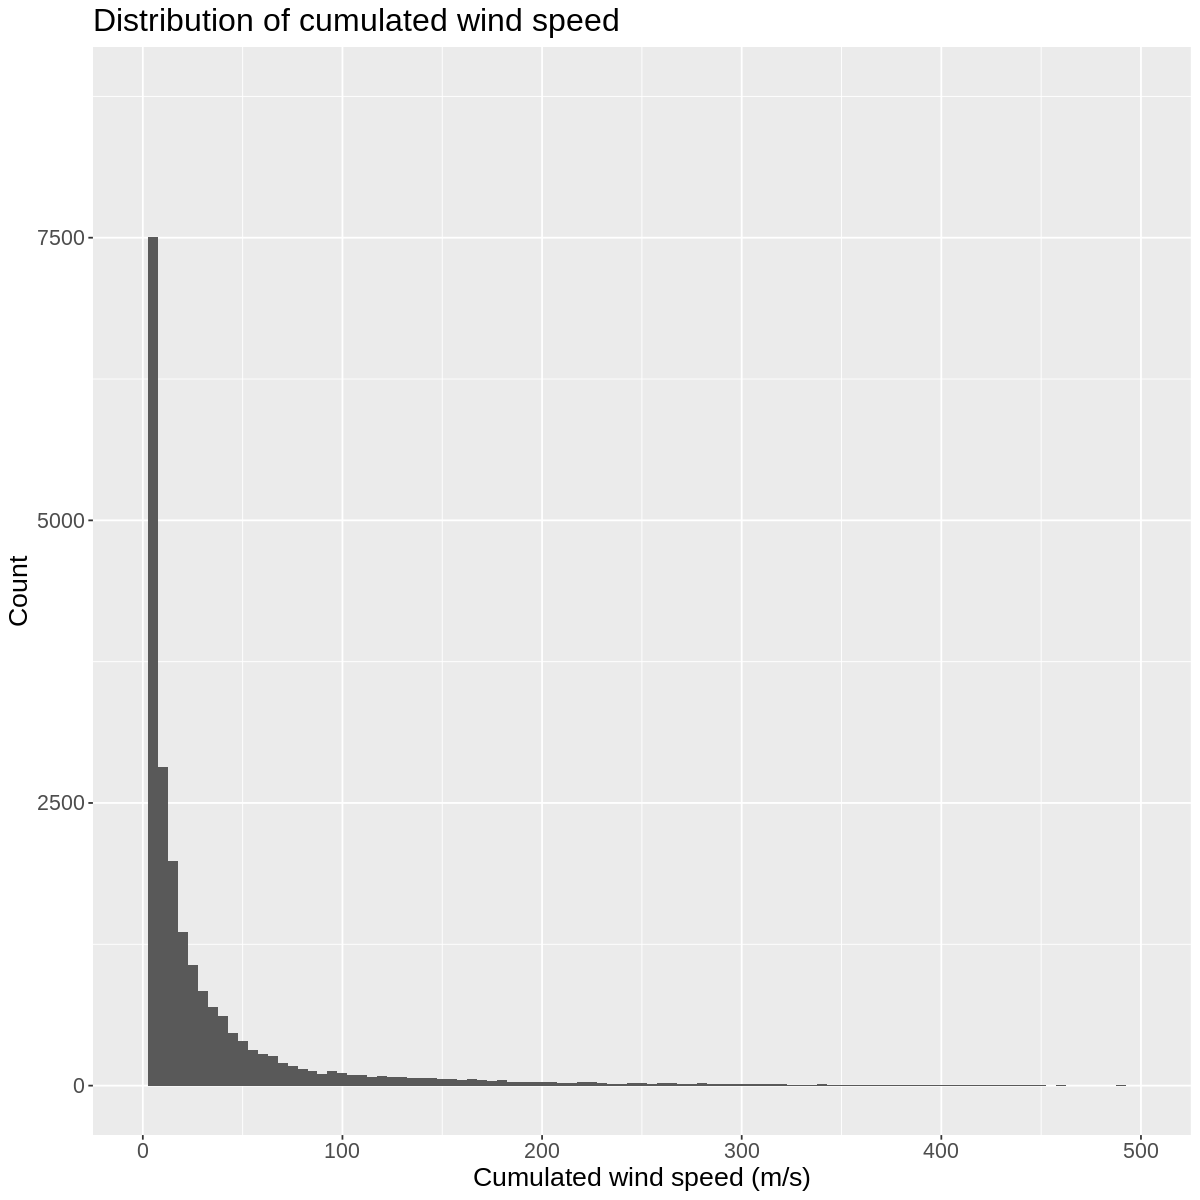

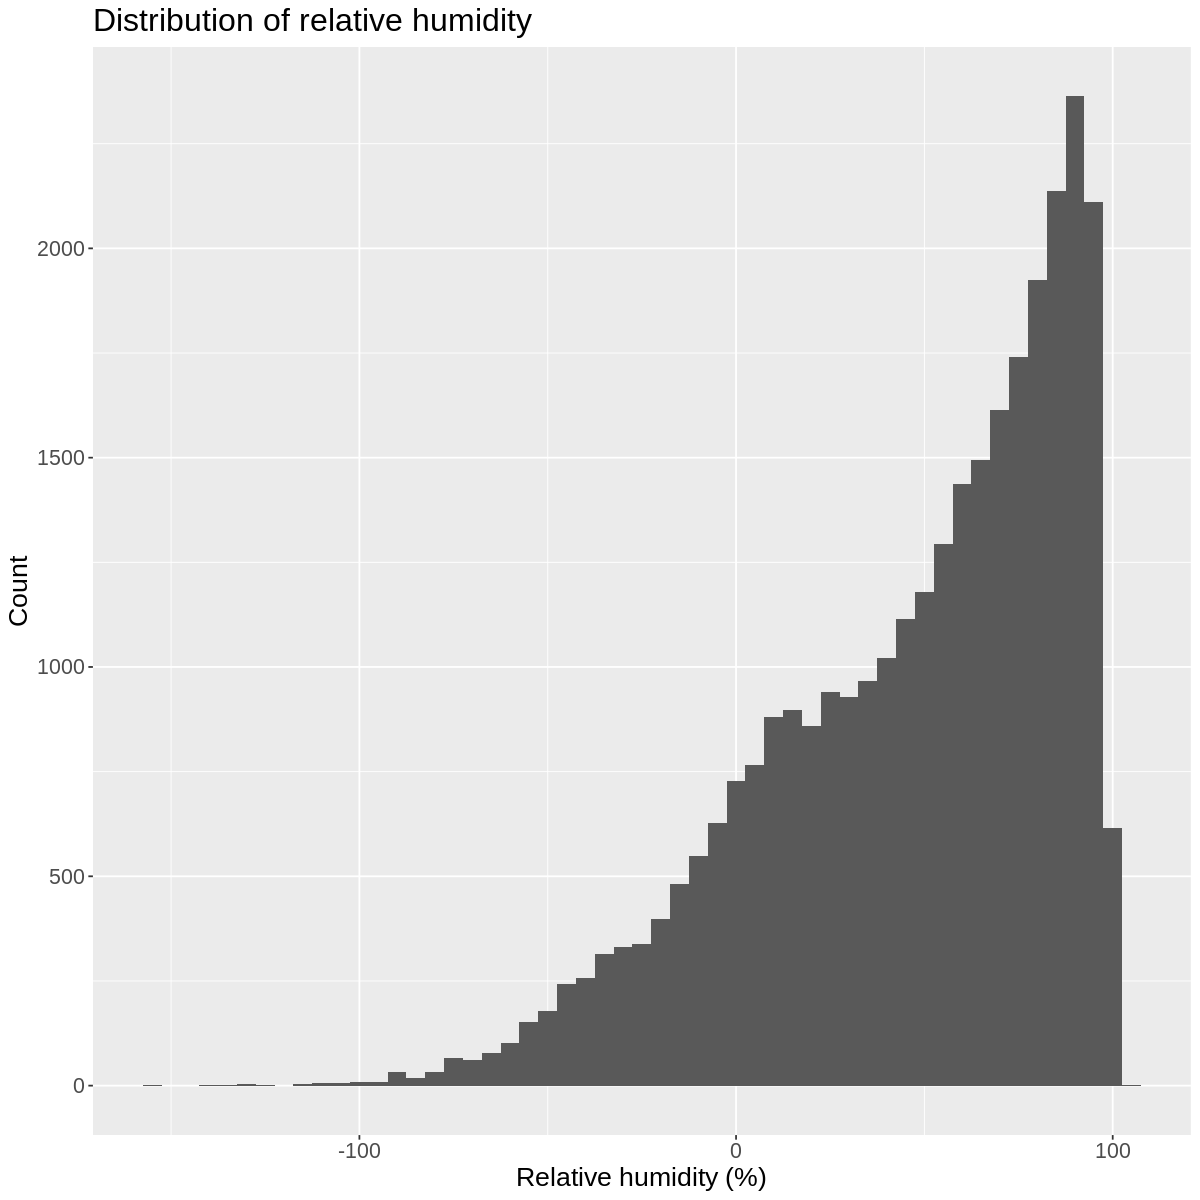

In [17]:
set.seed(9999)
options(repr.plot.width = 10, repr.plot.height = 10)

TEMP_pm2.5_total_plot <- ggplot(pollution_training, aes(x = TEMP)) +
#                                aes(x = TEMP, fill = pm2.5)) +
geom_histogram(binwidth = 1) + 
# geom_point() +
# geom_smooth() +
ggtitle("Distribution of temperatures") +
labs(x = "Temperature (°C)", y = "Count") +
theme(text = element_text(size = 16))
TEMP_pm2.5_total_plot

Iws_pm2.5_total_plot <- ggplot(pollution_training, aes(x = Iws)) +
#                               aes(x = Iws, fill = pm2.5)) +
geom_histogram(binwidth = 5) + 
# geom_point() +
# geom_smooth() +
ggtitle("Distribution of cumulated wind speed") +
labs(x = "Cumulated wind speed (m/s)", y = "Count") +
theme(text = element_text(size = 16)) +
xlim(0, 500) + 
ylim(0, 8750)
Iws_pm2.5_total_plot

HUMID_pm2.5_avg_plot <- ggplot(pollution_training, aes(x = HUMID)) +
#                               aes(x = HUMID, fill = pm2.5)) +
geom_histogram(binwidth = 5) + 
# geom_point() +
# geom_smooth() +
ggtitle("Distribution of relative humidity") + 
labs(x = "Relative humidity (%)", y = "Count") +
theme(text = element_text(size = 16))
HUMID_pm2.5_avg_plot

Next, we analyze the relationship between months in each year and pm2.5. Again, line plots are generated to exhibit the trend over time. For year and month, we use a facet grid of scatterplots to show the direction of PM2.5 concentration over the years and months.

`summarise()` regrouping output by 'year', 'month' (override with `.groups` argument)



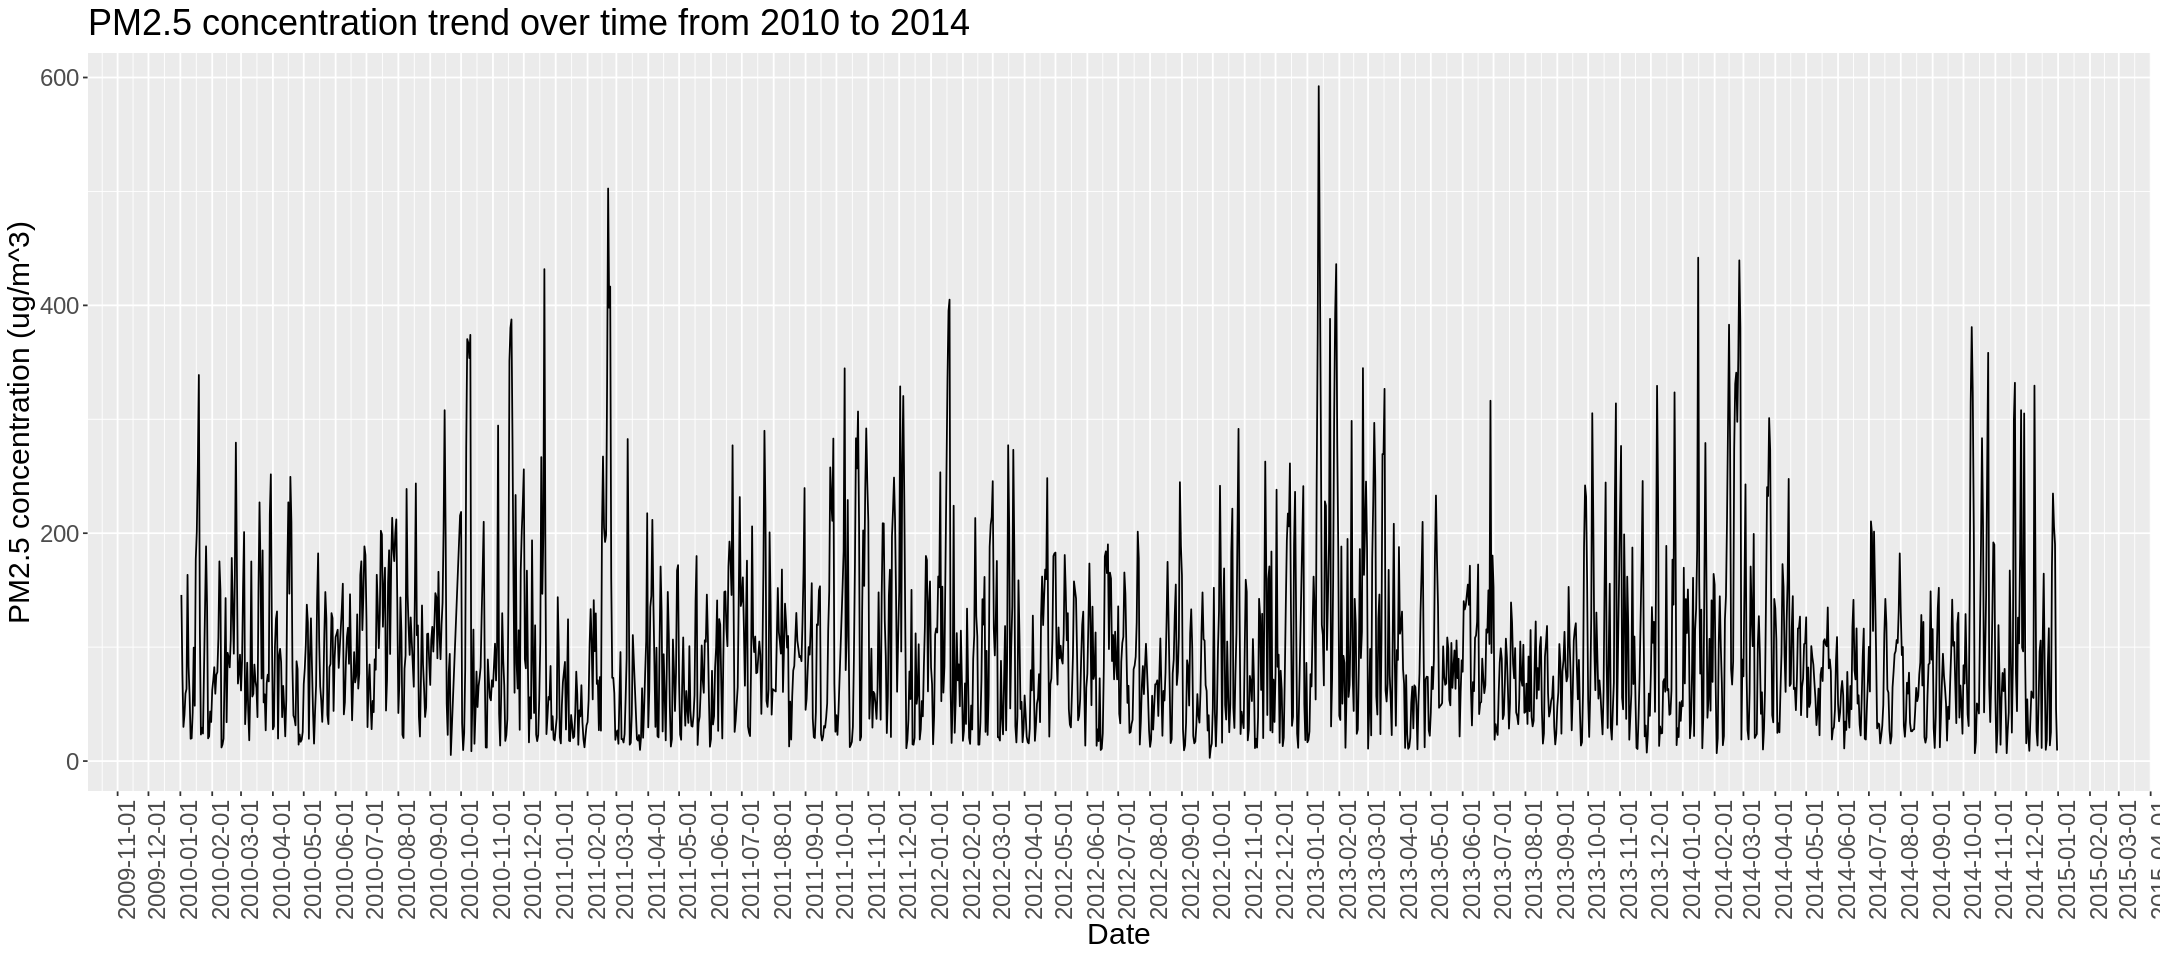

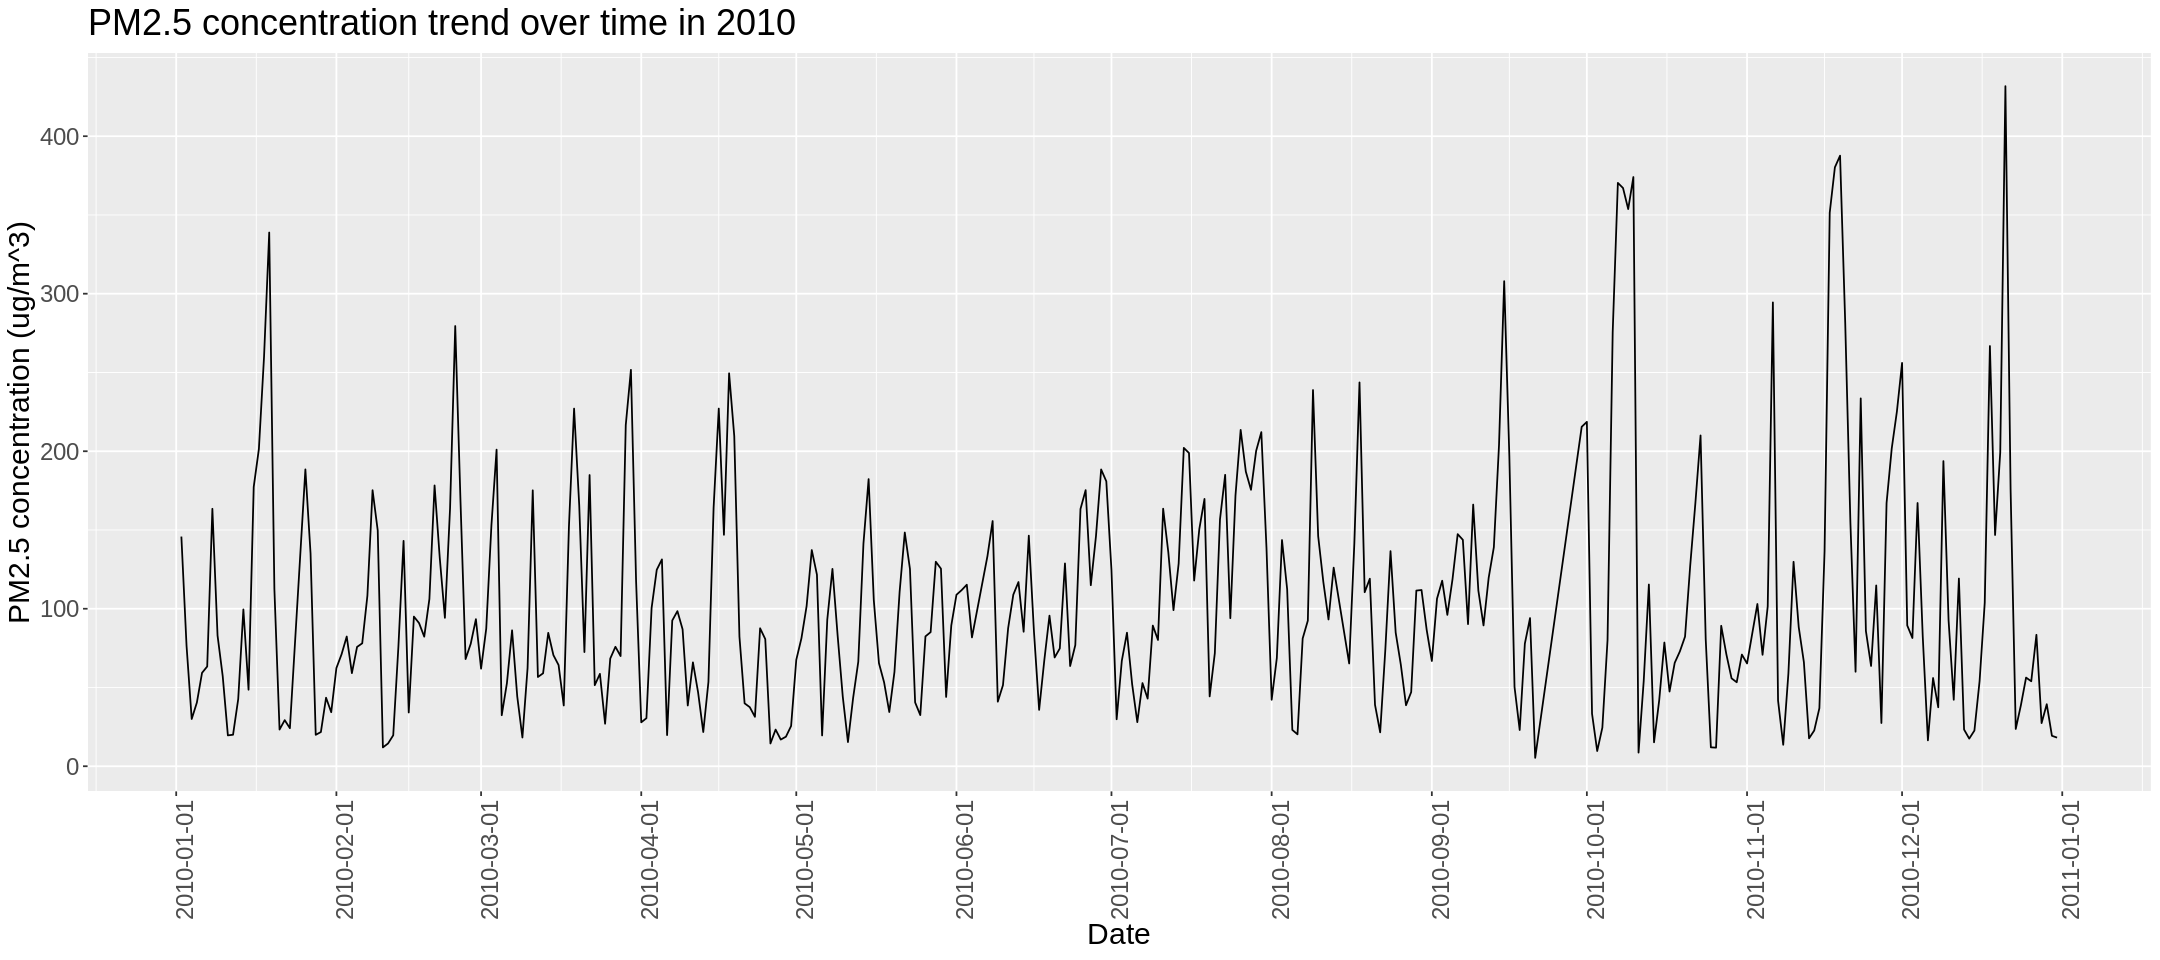

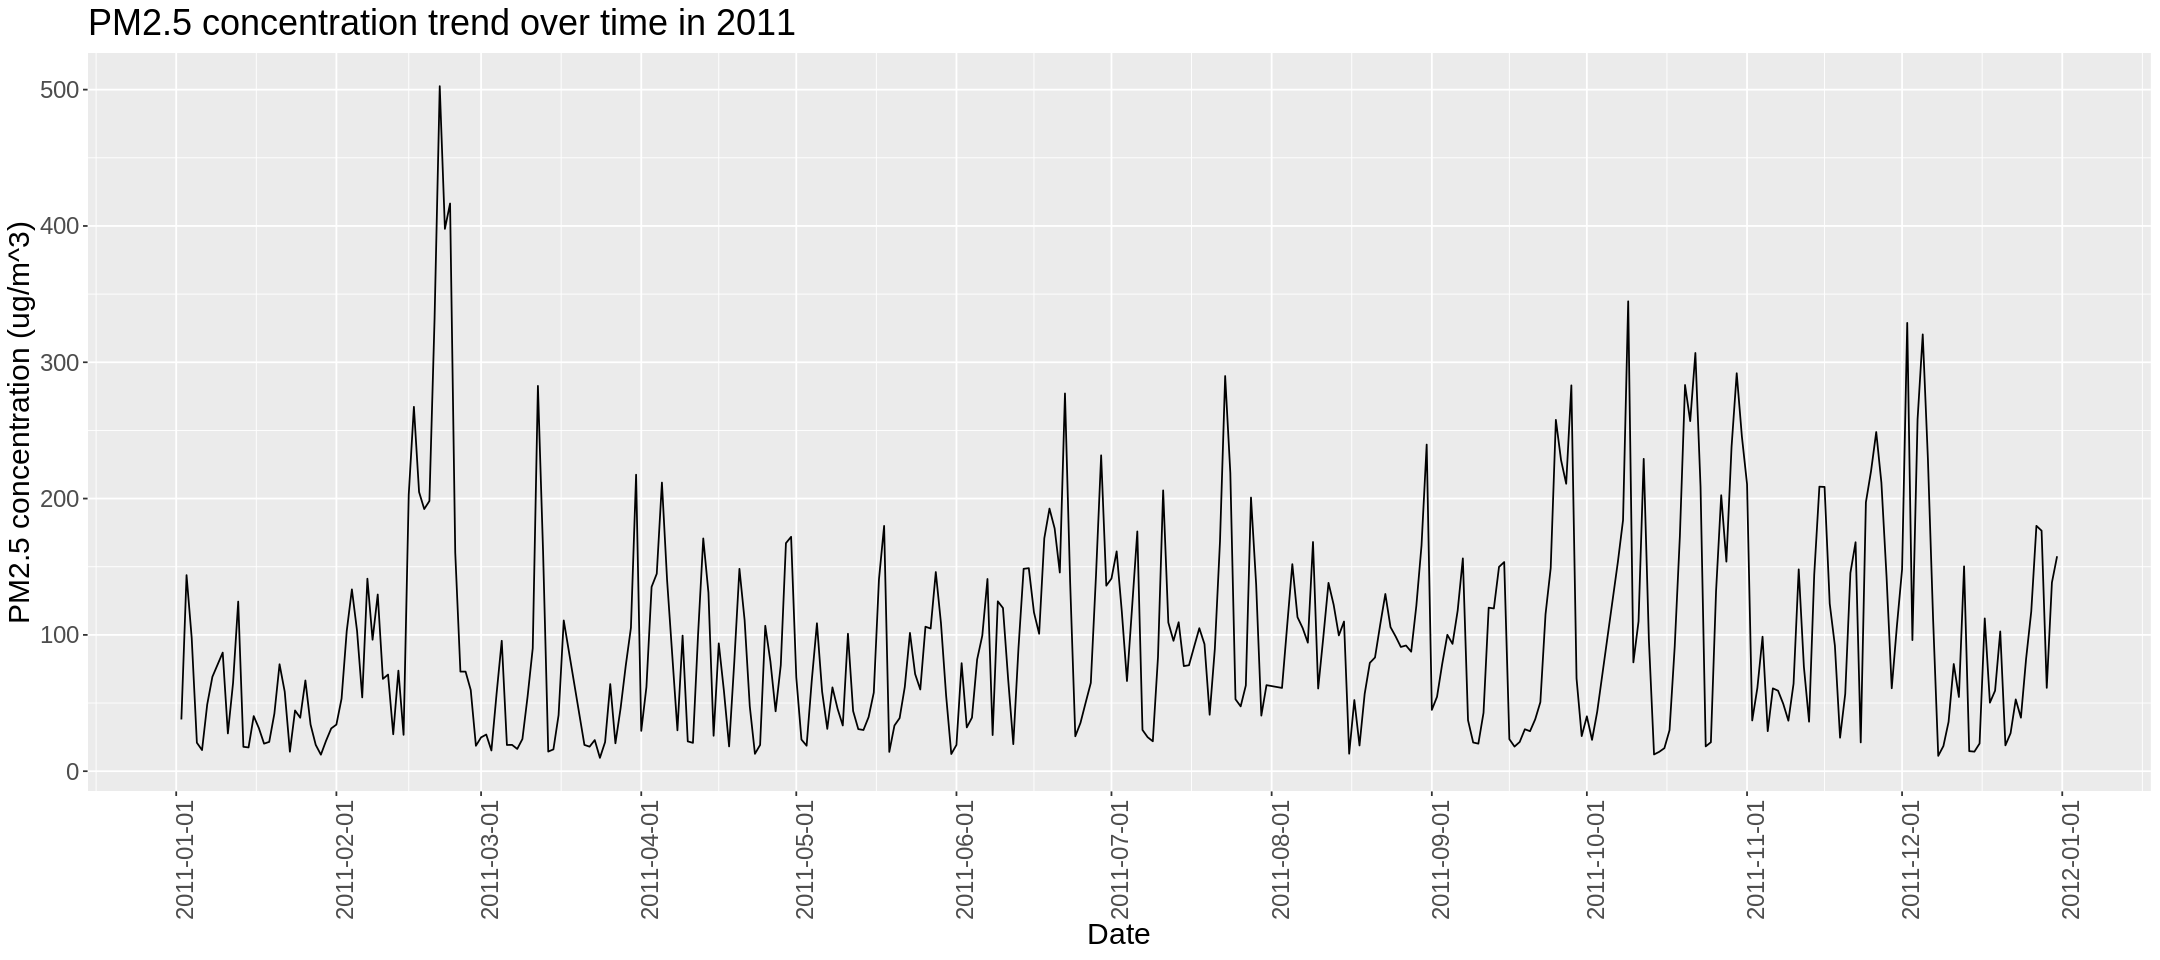

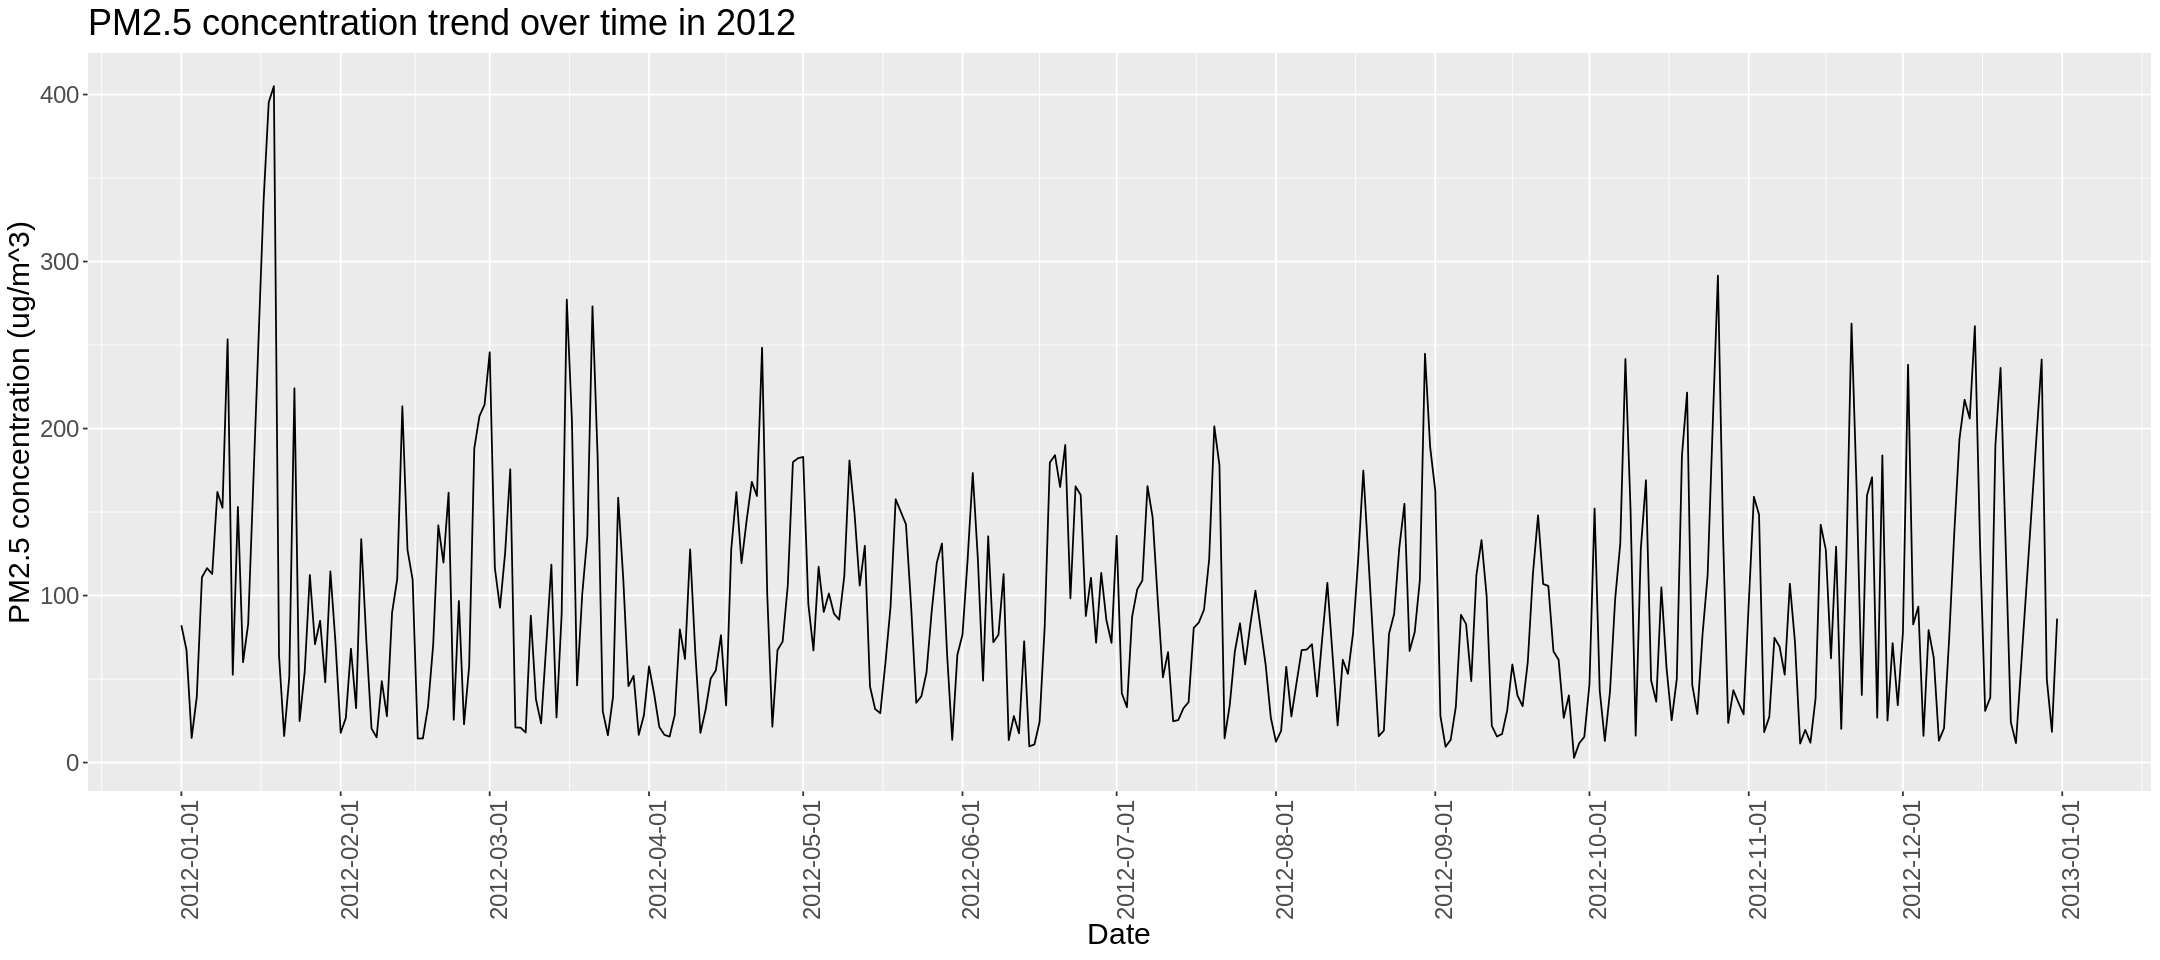

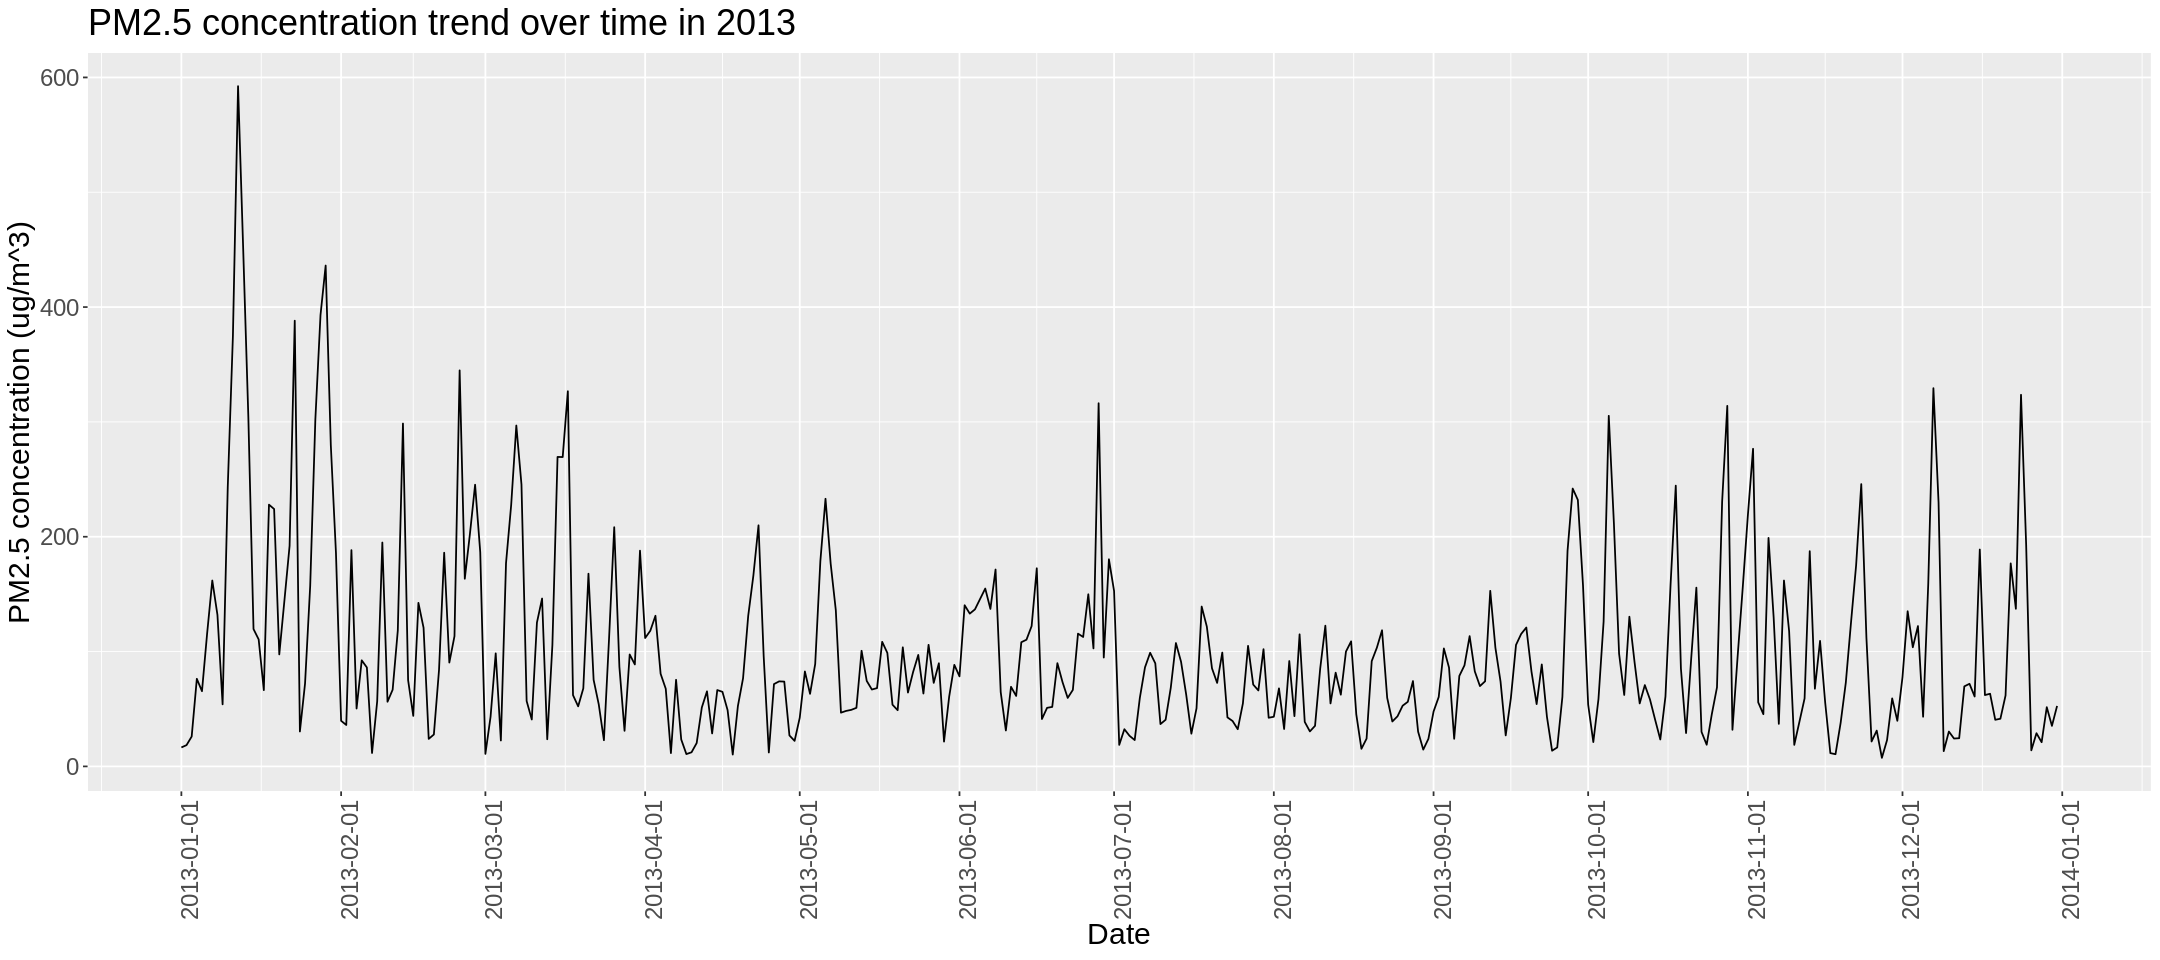

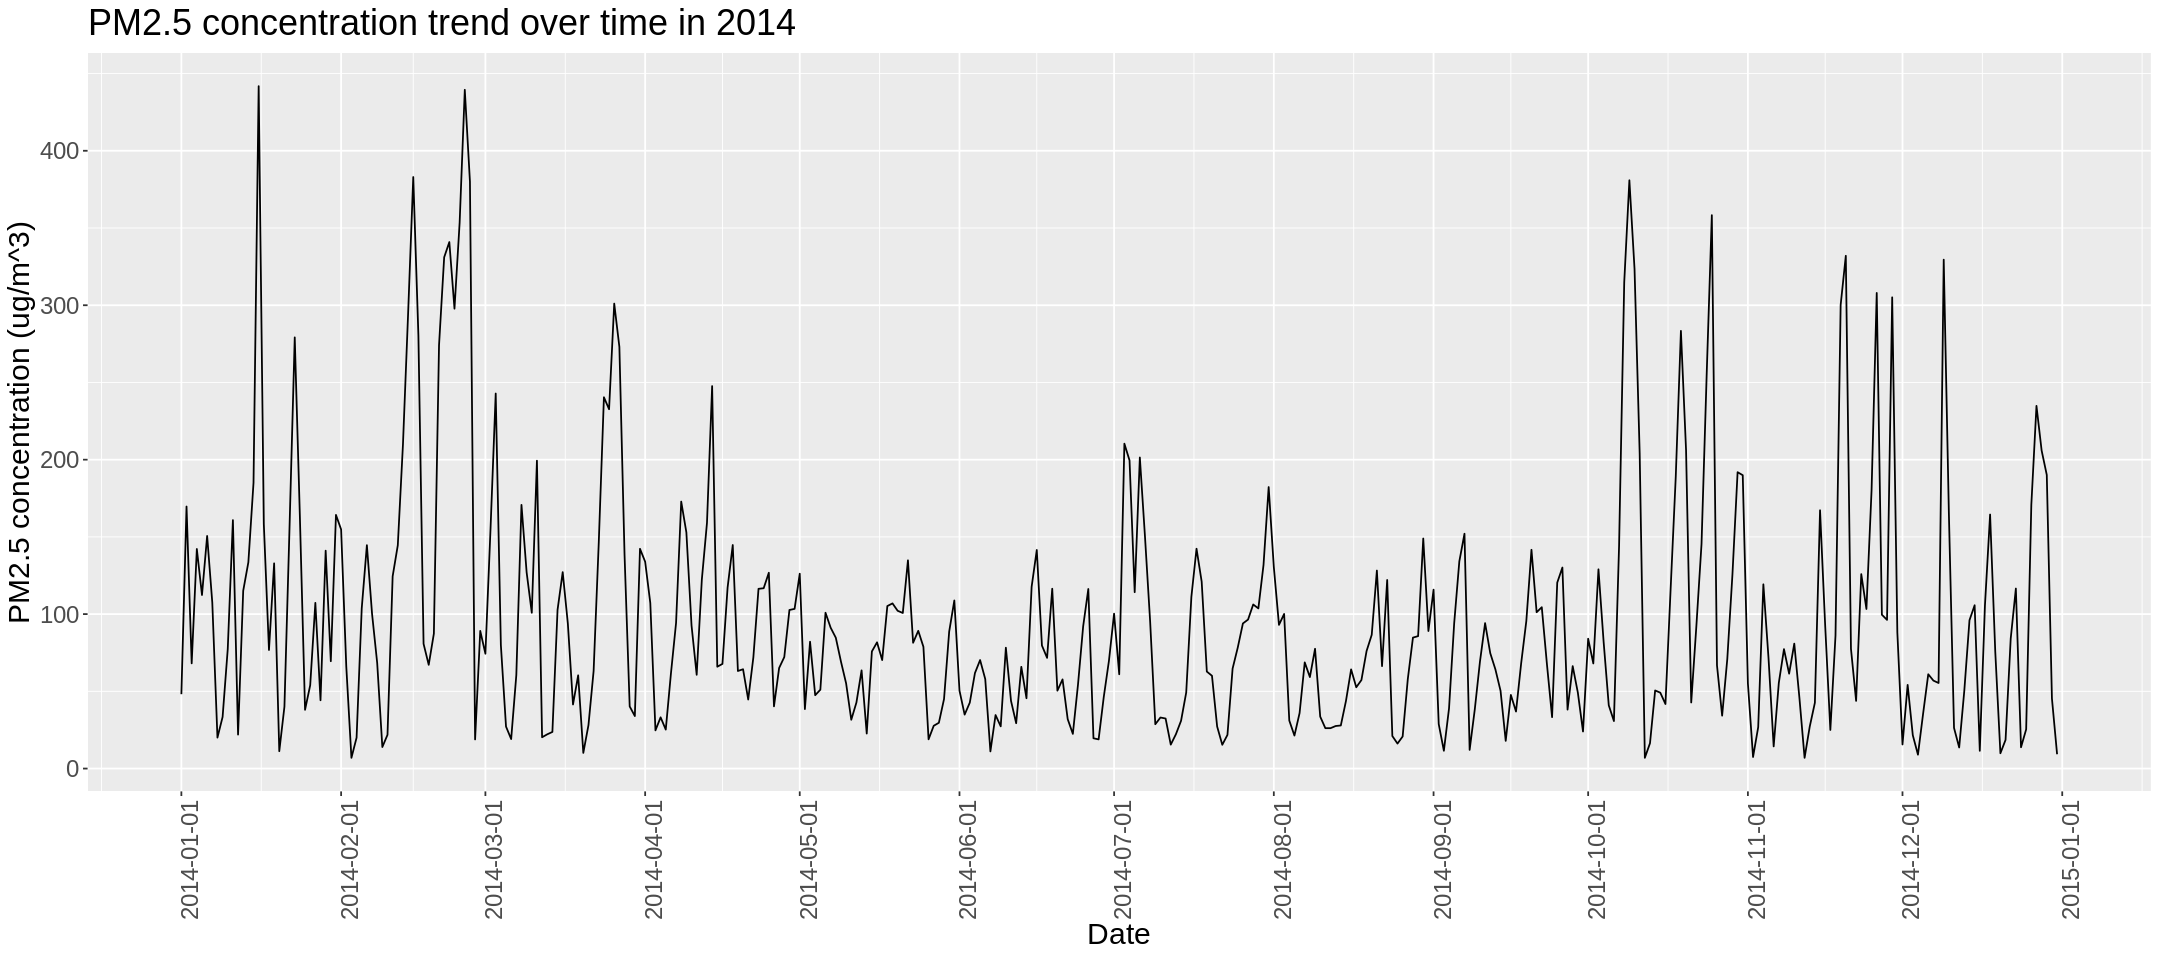

In [18]:
set.seed(9999)
options(repr.plot.width = 18, repr.plot.height = 8)
pm2.5_data <- pollution_training %>%
    select(year,month,day,pm2.5) %>%
    group_by(year,month,day) %>%
    summarise(pm2.5_avg = mean(pm2.5, na.rm = TRUE))
pm2.5_data$Date<-as.Date(with(pm2.5_data,paste(year,month,day,sep="-")),"%Y-%m-%d")

# pm2.5_data <- pollute_avg %>%
#     select(year,month,pm2.5_avg) %>%
#     group_by(year,month) %>%
#     summarise(pm2.5_avg = mean(pm2.5_avg, na.rm = TRUE))
# pm2.5_data$Date<-as.Date(with(pm2.5_data,paste(year,month,sep="-")),"%Y-%m")

pm2.5_time_total_plot <- ggplot(pm2.5_data, aes(x = Date, y = pm2.5_avg)) + 
     geom_line() +
     xlab("Date") +
     ylab("PM2.5 concentration (ug/m^3)") + 
    scale_x_date(date_breaks = "1 month") +
    ggtitle("PM2.5 concentration trend over time from 2010 to 2014") +
     theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
pm2.5_time_total_plot

pm2.5_time_2010_plot <- pm2.5_data %>%
filter(year == 2010) %>%
ggplot(aes(x = Date, y = pm2.5_avg)) + 
     geom_line() +
     xlab("Date") +
     ylab("PM2.5 concentration (ug/m^3)") + 
    scale_x_date(date_breaks = "1 month") + 
    ggtitle("PM2.5 concentration trend over time in 2010") +
     theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
pm2.5_time_2010_plot

pm2.5_time_2011_plot <- pm2.5_data %>%
filter(year == 2011) %>%
ggplot(aes(x = Date, y = pm2.5_avg)) + 
     geom_line() +
     xlab("Date") +
     ylab("PM2.5 concentration (ug/m^3)") + 
    scale_x_date(date_breaks = "1 month") + 
    ggtitle("PM2.5 concentration trend over time in 2011") +
     theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
pm2.5_time_2011_plot

pm2.5_time_2012_plot <- pm2.5_data %>%
filter(year == 2012) %>%
ggplot(aes(x = Date, y = pm2.5_avg)) + 
     geom_line() +
     xlab("Date") +
     ylab("PM2.5 concentration (ug/m^3)") + 
    scale_x_date(date_breaks = "1 month") +
    ggtitle("PM2.5 concentration trend over time in 2012") +
     theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
pm2.5_time_2012_plot

pm2.5_time_2013_plot <- pm2.5_data %>%
filter(year == 2013) %>%
ggplot(aes(x = Date, y = pm2.5_avg)) + 
     geom_line() +
     xlab("Date") +
     ylab("PM2.5 concentration (ug/m^3)") + 
     ggtitle("PM2.5 concentration trend over time in 2013") +
    scale_x_date(date_breaks = "1 month") + # labels every month
     theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
pm2.5_time_2013_plot

pm2.5_time_2014_plot <- pm2.5_data %>%
filter(year == 2014) %>%
ggplot(aes(x = Date, y = pm2.5_avg)) + 
     geom_line() +
     xlab("Date") +
     ylab("PM2.5 concentration (ug/m^3)") + 
    scale_x_date(date_breaks = "1 month") +
    ggtitle("PM2.5 concentration trend over time in 2014") +
     theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
pm2.5_time_2014_plot

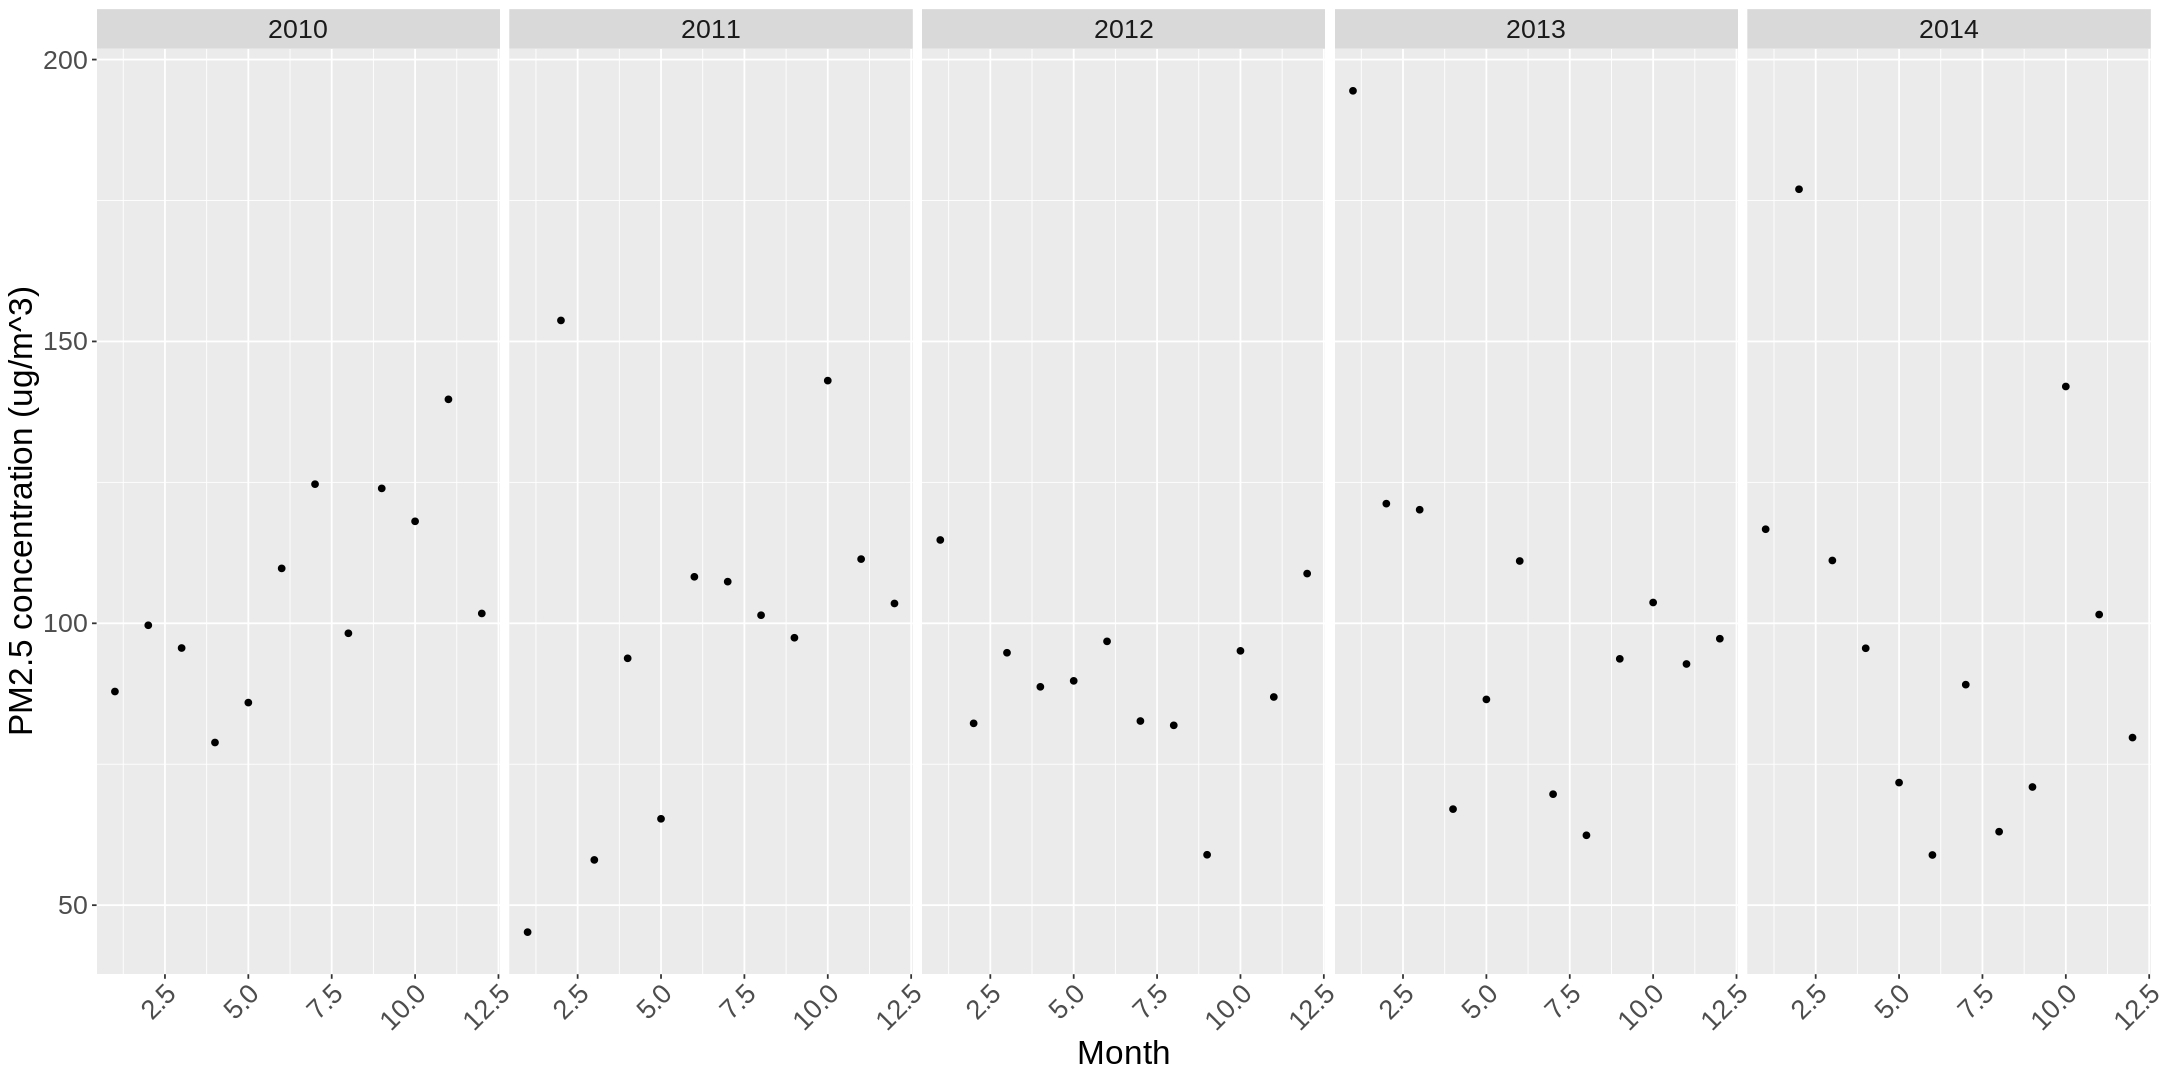

In [19]:
set.seed(9999)
options(repr.plot.width = 18, repr.plot.height = 9)
pm2.5_avg_plot <- pollute_avg %>%
    ggplot(aes(x = month, y = pm2.5_avg)) + 
    geom_point() +
    xlab("Month") + 
    ylab("PM2.5 concentration (ug/m^3)") +
    facet_grid(.~ year) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
         strip.text.y.left = element_text(angle = 0),
         text = element_text(size = 20))
pm2.5_avg_plot

## Conclusion
We expect to find the strength of the relationships between the three predictors and PM2.5 concentration. According to the graphs for TEMP, there is a slight negative correlation between temperature and PM2.5. This is to be expected, as an increase in temperature will lead to an increase in Brownian motion of particles in the air, causing PM2.5 to be more dispersed. 

Our findings will provide good suggestions for whether residents in Beijing can do outdoor activities under different conditions. However, one further question that we want to ask is whether different locations in Beijing lead to different PM 2.5 concentrations. Other factors that could affect PM2.5 concentration that should also be accounted for are air pressure and rainfall. The question is expected to be answered in the future as we do not have location data in our current dataset, nor do we have sufficient data to account for other potential factors.

## Citations:
- “California Air Resources Board.” Inhalable Particulate Matter and Health (PM2.5 and PM10) | California Air Resources Board, https://ww2.arb.ca.gov/resources/inhalable-particulate-matter-and-health#:~:text=For%20PM2.,symptoms%2C%20and%20restricted%20activity%20days. 
- Liang, X., Zou, T., Guo, B., Li, S., Zhang, H., Zhang, S., Huang, H. and Chen, S. X. (2015). Assessing Beijing's PM2.5 pollution: severity, weather impact, APEC and winter heating. Proceedings of the Royal Society A, 471, 20150257.
- Sun, Ruiling, et al. “Influencing Factors of PM2.5 Pollution: Disaster Points of Meteorological Factors.” International Journal of Environmental Research and Public Health, MDPI, 14 Oct. 2019, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6843796/. 